# Time Series Forecasting Using ARIMA Method

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/laamsang/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Loading

In [2]:
df = pd.read_json('../pm25_05t.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1357
Data columns (total 3 columns):
05t_PM2.5 (ug/m3)             1358 non-null object
24hr_average_PM2.5 (ug/m3)    1358 non-null float64
DateTime                      1358 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.4+ KB


In [3]:
pm25 = df[['DateTime', '24hr_average_PM2.5 (ug/m3)']]
pm25.set_index('DateTime', inplace=True)
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1358 entries, 2018-01-01 00:00:00 to 2018-02-26 12:00:00
Data columns (total 1 columns):
24hr_average_PM2.5 (ug/m3)    1358 non-null float64
dtypes: float64(1)
memory usage: 21.2 KB


In [4]:
print(pm25.head())

                     24hr_average_PM2.5 (ug/m3)
DateTime                                       
2018-01-01 00:00:00                   25.780000
2018-01-01 01:00:00                   22.360000
2018-01-01 02:00:00                   20.516667
2018-01-01 03:00:00                   18.362500
2018-01-01 04:00:00                   16.504000


In [5]:
# y = pd.Series(data=pm25['24hr_average_PM2.5 (ug/m3)'], index = pm25.index.tolist())
y = pm25

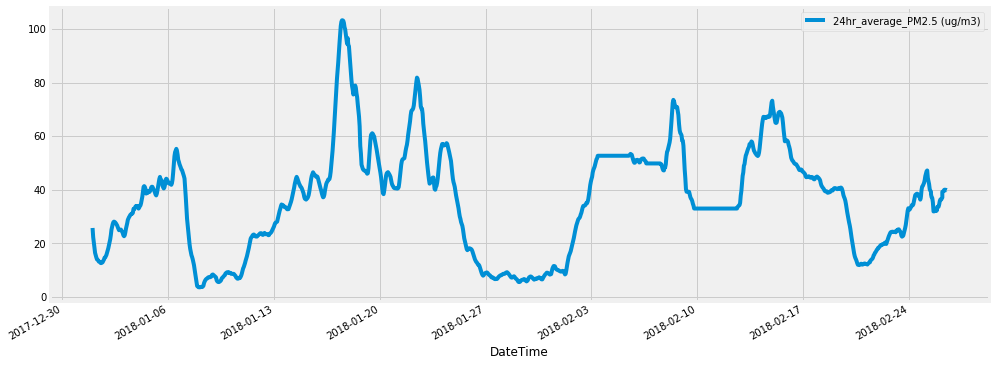

In [6]:
y.plot(figsize=(15, 6))
plt.show()

## Forecasting

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [8]:
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [9]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [10]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 30)
SARIMAX: (0, 0, 1) x (0, 1, 0, 30)
SARIMAX: (0, 1, 0) x (0, 1, 1, 30)
SARIMAX: (0, 1, 0) x (1, 0, 0, 30)


In [11]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [12]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [13]:
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2237.9886012727948 => the lowest AIC
# ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:2217.830016736297
# ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:2211.5450748568883

# ARIMA(1, 1, 0)x(1, 0, 0, 30)12 - AIC:2288.586661125933
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 30),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8437      0.010     81.878      0.000       0.823       0.864
ma.L1         -0.0215      0.016     -1.321      0.187      -0.054       0.010
sigma2         0.3418      0.006     60.061      0.000       0.331       0.353


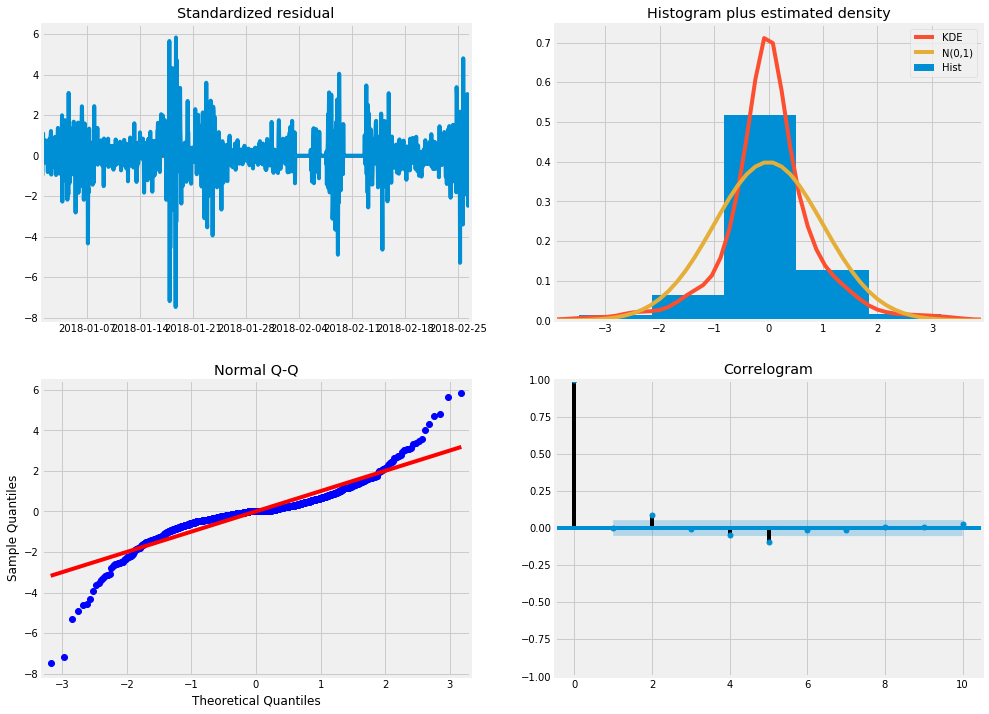

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-25 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

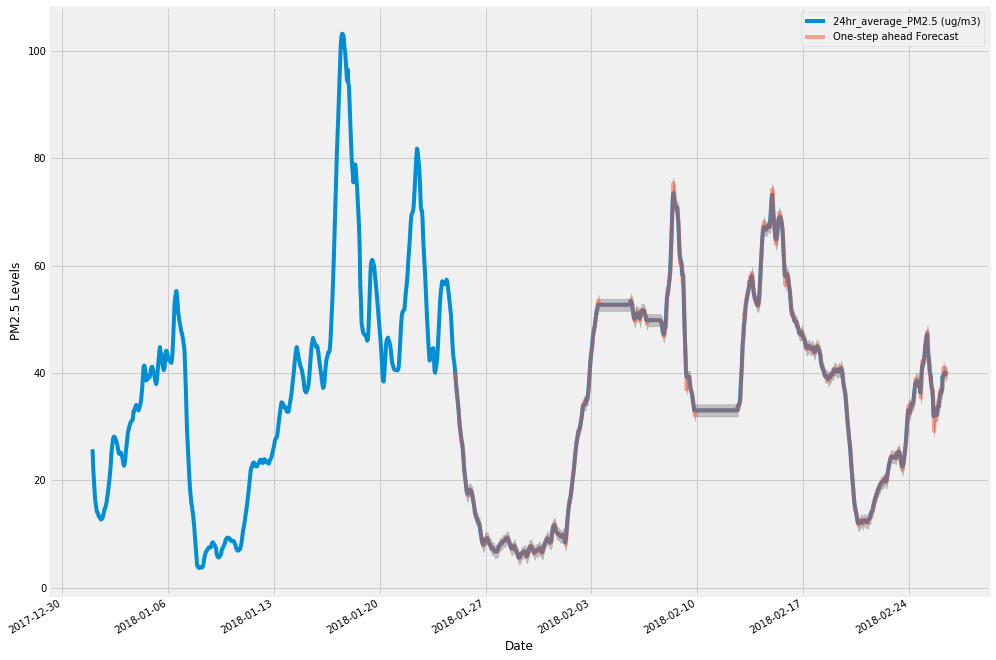

In [16]:
ax = y['2018':].plot(label='observed',figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 Levels')
plt.legend()

plt.show()

In [17]:
y_forecasted = pred.predicted_mean
y_truth = pd.Series(data = y['2018-01-01':]['24hr_average_PM2.5 (ug/m3)'], index = y['2018-01-01':].index.tolist()) 
#print(y_forecasted)
#print(y_truth)
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.26


In [18]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-25 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

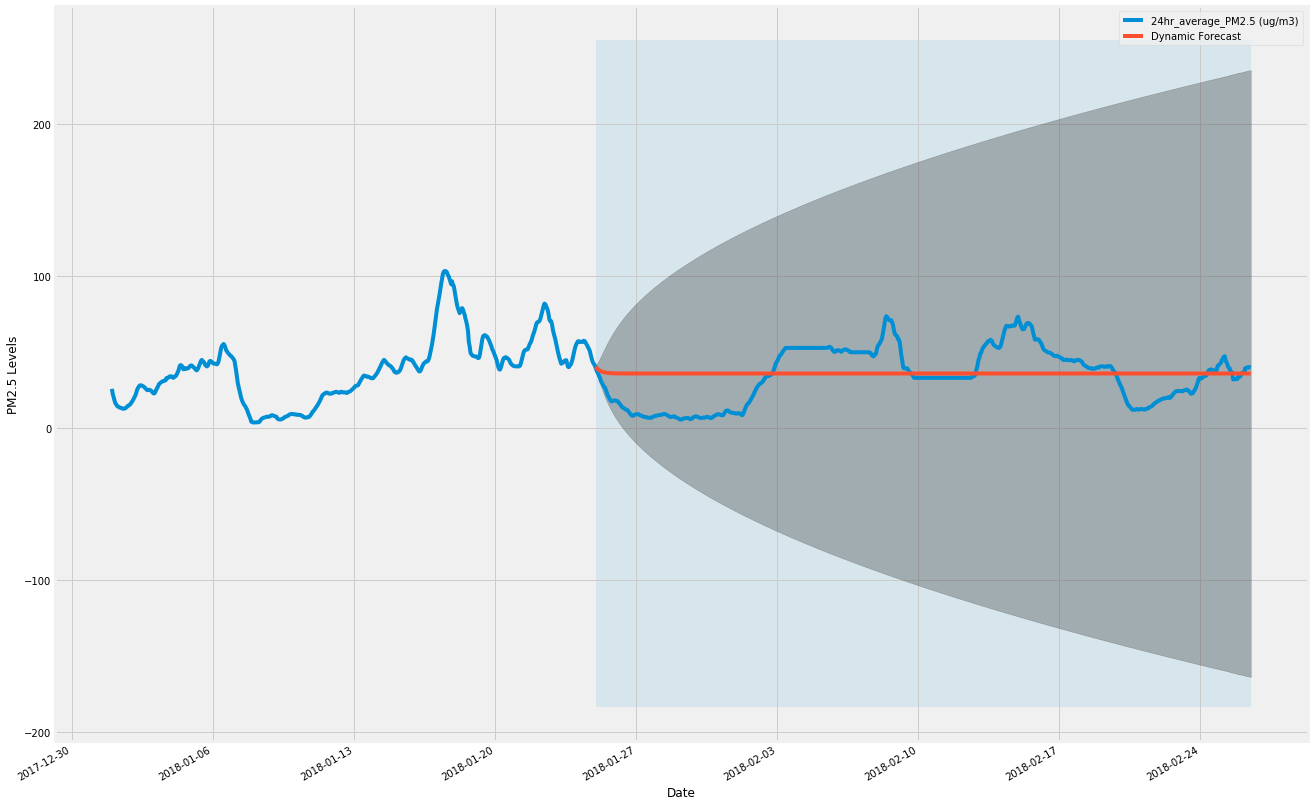

In [19]:
ax = y['2018':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-25'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 Levels')

plt.legend()
plt.show()

In [20]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = pd.Series(data = y['2018-01-01':]['24hr_average_PM2.5 (ug/m3)'], index = y['2018-01-01':].index.tolist())

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 333.39


In [21]:
from pandas.tools.plotting import autocorrelation_plot

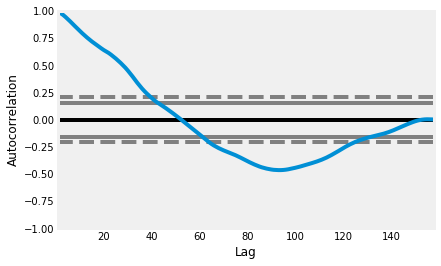

In [29]:
from matplotlib import pyplot
autocorrelation_plot(y['2018-02-20':])
pyplot.show()

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# fit model
model = ARIMA(y, order=(30,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [23]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [ ]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 Levels')

plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
X = y.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))